In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from data_loading import read_hackathon_data

from metrics.metrics_time import TimeMetrics
from itertools import product

df = pd.read_csv('../data/all_experiments-25-08.csv', index_col=0).reset_index()
df['task'] = 'task2'
df.loc[df.notebook_name.str.contains('task1'), 'task'] = 'task1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Execution time

In [50]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

In [63]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

In [64]:
sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].sum()).to_frame('exec_time_sum') / 60
sum_exec_count = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].count()).to_frame('exec_time_count')
sum_exec_mean = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'state_time_dt'].mean()).to_frame('exec_time_mean') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60

kernel_time_df = kernel_mapping.merge(sum_exec, on = 'kernel_id').merge(sum_exec_mean, on = 'kernel_id').merge(sum_all, on = 'kernel_id').merge(sum_exec_count, on = 'kernel_id')
kernel_time_df['percent'] = kernel_time_df.exec_time_sum / kernel_time_df.overall_time * 100
kernel_time_df['exec_time_n'] = kernel_time_df.exec_time_sum / kernel_time_df.exec_time_count
exec_comp = kernel_time_df.groupby(['task', 'expert']).describe()

(1963, 9207)

In [65]:
cols = list(product(['exec_time_sum', 'percent','exec_time_n'],['mean', 'std']))
lop = exec_comp.loc[:,cols]
print(lop.round(2).applymap('{:.2f}'.format).to_latex(escape = True, multirow=True))


,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,labels,task,expert,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,22.731
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,162.0,NaN,4.652
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,0.822
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,"helper_functions,",task1,False,NaT,NaT,NaN,0,20.0,NaN,1.788
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,"helper_functions,",task1,False,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,0.755


In [66]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].dropna()

In [67]:
execs.anova(dv="state_time_dt", between=["expert", "task"]).round(3)

\begin{tabular}{llllllll}
\toprule
 &  & \multicolumn{2}{r}{exec\_time\_sum} & \multicolumn{2}{r}{percent} & \multicolumn{2}{r}{exec\_time\_n} \\
 &  & mean & std & mean & std & mean & std \\
task & expert &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{task1} & False & 15.49 & 13.89 & 7.60 & 8.48 & 0.05 & 0.02 \\
 & True & 4.85 & 4.12 & 2.94 & 2.58 & 0.02 & 0.02 \\
\cline{1-8}
\multirow[t]{2}{*}{task2} & False & 28.61 & 27.40 & 11.87 & 9.52 & 0.12 & 0.08 \\
 & True & 30.83 & 38.96 & 14.20 & 13.35 & 0.09 & 0.10 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [68]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

In [69]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [70]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.46,16.83,two-sided,0.16,"[-33.81, 185.78]",0.51,0.868,0.15


# Action time

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67,10,two-sided,0.52,"[-0.08, 0.15]",0.39,0.54,0.09


In [73]:
metrics = metrics[metrics.notebook_name.isin(['task1.ipynb', 'task2.ipynb'])]

labels
comment_only,                               0.706887
data_exploration,                           1.993690
data_exploration,modelling,                 0.907250
data_exploration,result_visualization,      1.307600
data_preprocessing,                         2.941622
data_preprocessing,data_exploration,        4.355762
evaluation,                                 0.075000
helper_functions,                           3.816076
helper_functions,data_exploration,          0.432889
helper_functions,data_preprocessing,        1.681864
helper_functions,evaluation,                0.125865
helper_functions,load_data,                 5.378083
helper_functions,modelling,                24.487443
load_data,                                  0.643182
load_data,data_exploration,                 0.599867
modelling,                                 23.950961
modelling,evaluation,                     115.759000
prediction,                                 0.540155
result_visualization,                  

In [74]:
metrics_long =  metrics.loc[:,['notebook_name','event','expert','next_action_time', 'interruptions', 'state_time_dt']]

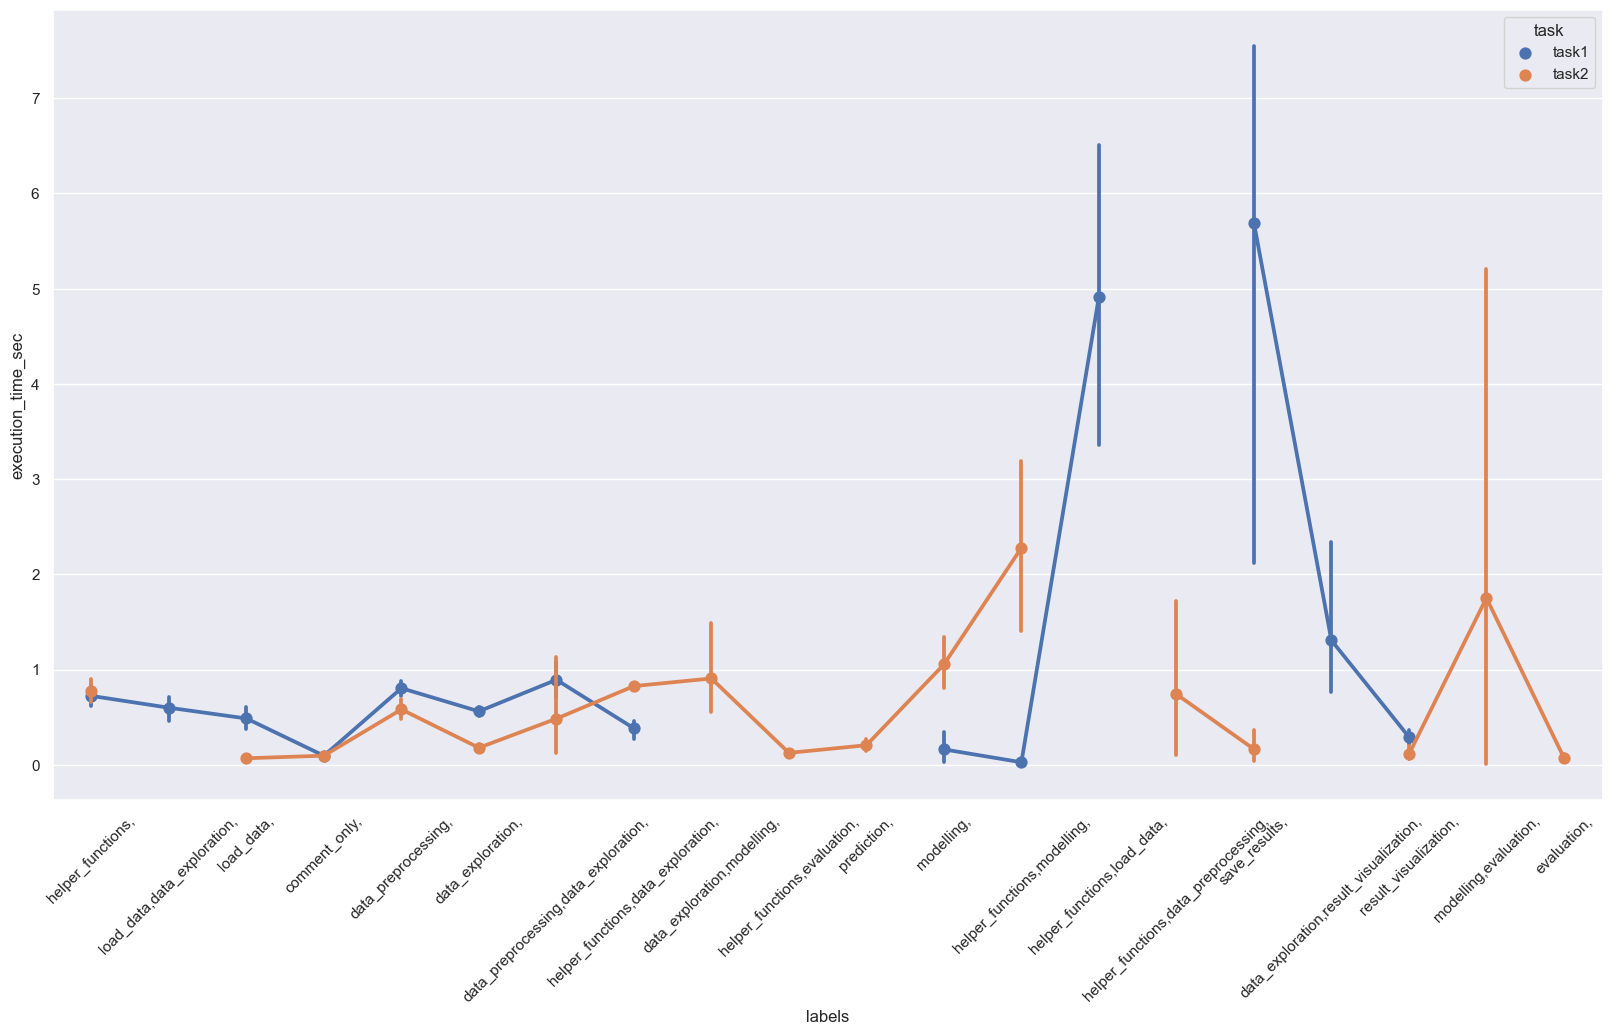

In [75]:
metrics_long = metrics_long.melt(id_vars=['notebook_name','event','expert', 'state_time_dt'])

In [154]:
interruptions = metrics_long[(metrics_long.variable == 'interruptions')&(metrics_long.event == 'execute')]

,state_num,cell_index,cell_num,cell_source,index,time,session_id,kernel_id,notebook_name,event,cell_type,cell_output,user_id,labels,task,expert,action_id
0,1,35c0b3b694f84140846a21197ea62f68,0.0,# # Do not forget to check if your notebook lo...,0.0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,student_7,None,task1,False,0.0
0,2,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,1.0,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"helper_functions,",task1,False,1.0
0,3,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,2.0,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,"helper_functions,",task1,False,2.0
0,4,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,3.0,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,code,None,student_7,"helper_functions,",task1,False,3.0
0,5,35c0b3b694f84140846a21197ea62f68,0.0,from mining_extension import check_logging \nc...,4.0,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""stream"",""size"":23}]",student_7,"helper_functions,",task1,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,307,35c0b3b694f84140846a21197ea62f68,0.0,!pip install pandas\n!pip install np\n!pip ins...,2069.0,2023-05-06 12:46:53.474,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""error"",""size"":0}]",student_7,"data_exploration,",task1,False,2069.0
1,307,8d8ae31069ce43968d38872daa3b97c6,1.0,import pandas as pd\nimport numpy as np\nimpor...,2069.0,2023-05-06 12:46:53.474,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""error"",""size"":0}]",student_7,"data_exploration,",task1,False,2069.0
2,307,f587a4dc26a6401d9941dfbb718b5ecf,2.0,"PATH_TO_DATA = ""./data/task1/jetnet_logs/jetne...",2069.0,2023-05-06 12:46:53.474,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""error"",""size"":0}]",student_7,"data_exploration,",task1,False,2069.0
3,307,ac7a0f832e974e0d87afc97bfe257476,3.0,"df.sort_values(by=""action_time"")",2069.0,2023-05-06 12:46:53.474,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,code,"[{""output_type"":""error"",""size"":0}]",student_7,"data_exploration,",task1,False,2069.0


# Action time

In [139]:
tips = sns.load_dataset("tips")

,kernel_id,index,nb_len
0,0033f76c-6179-4fb4-a9ce-79112a52b51c,0,0
1,0033f76c-6179-4fb4-a9ce-79112a52b51c,1,1
2,0033f76c-6179-4fb4-a9ce-79112a52b51c,2,1
3,0033f76c-6179-4fb4-a9ce-79112a52b51c,3,2
4,0033f76c-6179-4fb4-a9ce-79112a52b51c,4,2
...,...,...,...
20843,fbb11760-eda3-4233-b800-12e732df766b,20843,172
20844,fbb11760-eda3-4233-b800-12e732df766b,20844,173
20845,fbb11760-eda3-4233-b800-12e732df766b,20845,173
20846,fbb11760-eda3-4233-b800-12e732df766b,20846,174


In [138]:
interruptions

,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,expert,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time,current_nb_len,nb_len
0,1113,2023-05-06 11:58:35.270,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,False,0 days 00:00:22.731000,2023-05-06 11:58:35.270,stream,0,162.0,22.731,22.731,1113,NaN
1,1114,2023-05-06 11:58:58.001,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,e139884774504ae997d7e38e6be6da88,0.0,code,# # Do not forget to check if your notebook lo...,...,False,NaT,NaT,NaN,0,162.0,NaN,4.652,1114,NaN
2,1116,2023-05-06 11:59:02.653,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,a47800e62cbe40c1ad4003b2879f5f03,1.0,code,!pip install pandas\n,...,False,0 days 00:00:00.822000,2023-05-06 11:59:02.653,stream,0,20.0,0.822,0.822,1116,NaN
3,1117,2023-05-06 11:59:03.475,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,finished_execute,a47800e62cbe40c1ad4003b2879f5f03,2.0,code,!pip install pandas\n,...,False,NaT,NaT,NaN,0,20.0,NaN,1.788,1117,NaN
4,1118,2023-05-06 11:59:05.263,7215278a-b19d-477e-82df-9a03bb979fb6,0033f76c-6179-4fb4-a9ce-79112a52b51c,task1.ipynb,execute,832d6ff5591b46a0ab57d4f57fb6bff4,2.0,code,!pip install sklearn,...,False,0 days 00:00:00.755000,2023-05-06 11:59:05.263,stream,0,20.0,0.755,0.755,1118,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20843,19742,2023-07-03 15:49:31.530,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,6e3d3614064748888cc82a221f924fd4,75.0,code,None,...,True,NaT,NaT,NaN,0,NaN,NaN,2.149,19742,22.0
20844,19743,2023-07-03 15:49:33.679,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,execute,6e3d3614064748888cc82a221f924fd4,76.0,code,y_pred,...,True,0 days 00:00:00.144000,2023-07-03 15:49:33.679,execute_result,1,6.0,0.144,0.034,19743,22.0
20845,19744,2023-07-03 15:49:33.713,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,create,30506d3f2fce44f18584f719e752d811,76.0,code,None,...,True,NaT,NaT,NaN,0,NaN,NaN,0.110,19744,22.0
20846,19745,2023-07-03 15:49:33.823,b5ba1f4c-9687-4b0a-bc3f-94ca134343d7,fbb11760-eda3-4233-b800-12e732df766b,task2.ipynb,finished_execute,6e3d3614064748888cc82a221f924fd4,77.0,code,y_pred,...,True,NaT,NaT,NaN,0,6.0,NaN,2.937,19745,22.0


In [142]:
interruptions.columns

In [146]:
g = sns.FacetGrid(interruptions, col="notebook_name",  row="expert")
g.map(sns.scatterplot, "state_time_dt", "value")

In [151]:
metrics.loc[:, ['next_action_time', 'event']].groupby('event').describe()

,index,time,session_id,kernel_id_x,notebook_name,event,cell_index,cell_num,cell_type,cell_source,...,execution_time,execution_start,result,interruptions,src_len,execution_time_sec,next_action_time,current_nb_len,kernel_id_y,nb_len
2191,15763,2023-05-22 12:03:57.461,0f54c11b-b98e-4f62-8882-df72cd2b3d13,232bcb48-7455-4109-9eeb-809649a6bedc,task2.ipynb,execute,17a5f167415448768c0369ba8672cb17,38.0,code,# # Do not forget to check if your notebook lo...,...,0 days 00:00:00.052000,2023-05-22 12:03:57.461,,35,160.0,0.052,0.002,15763,bc147b33-fa74-4bff-9f48-c88809c5bdcd,52
2312,15892,2023-05-22 14:12:31.464,0f54c11b-b98e-4f62-8882-df72cd2b3d13,232bcb48-7455-4109-9eeb-809649a6bedc,task2.ipynb,execute,17a5f167415448768c0369ba8672cb17,38.0,code,# # Do not forget to check if your notebook lo...,...,0 days 00:00:00.052000,2023-05-22 14:12:31.464,,34,160.0,0.052,0.001,15892,bc147b33-fa74-4bff-9f48-c88809c5bdcd,53
10079,11875,2023-05-06 18:39:52.301,82dc9c31-d202-4aec-9020-e28af8750416,81607d1b-0c4b-430e-b216-7b91e68a8a9a,task1.ipynb,execute,109b27c2a80146a08a543d8b04de1d58,2.0,code,# # Do not forget to check if your notebook lo...,...,0 days 00:00:00.298000,2023-05-06 18:39:52.301,stream,30,162.0,0.298,0.001,11875,81607d1b-0c4b-430e-b216-7b91e68a8a9a,74
10017,11788,2023-05-06 18:38:15.754,82dc9c31-d202-4aec-9020-e28af8750416,81607d1b-0c4b-430e-b216-7b91e68a8a9a,task1.ipynb,execute,109b27c2a80146a08a543d8b04de1d58,36.0,code,# # Do not forget to check if your notebook lo...,...,0 days 00:00:00.265000,2023-05-06 18:38:15.754,stream,30,162.0,0.265,0.002,11788,81607d1b-0c4b-430e-b216-7b91e68a8a9a,74
8924,12439,2023-05-06 19:02:21.261,17bdc126-61aa-43f4-a559-304b85857cc2,671c08d4-f227-4f23-b0ac-6842c4187641,task1.ipynb,execute,9d3c72b497004ffbbafb12f0c5fa3b08,54.0,code,# Do not forget to check if your notebook log ...,...,0 days 00:00:00.288000,2023-05-06 19:02:21.261,stream,29,160.0,0.288,0.002,12439,8a599028-9e81-4862-ad7f-15500e742f27,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279,6420,2023-05-06 15:21:20.222,387fc734-8ea2-4f9f-9295-5fbda1d8326d,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1.ipynb,finished_execute,3b453244116947b88fb58535bc52e7cc,61.0,code,actions_count = df2.groupby('action_name').siz...,...,NaT,NaT,NaN,0,438.0,NaN,20.238,6420,36c724d9-3a5f-43e2-aba2-2d0933046f35,128
6280,6427,2023-05-06 15:21:40.460,387fc734-8ea2-4f9f-9295-5fbda1d8326d,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1.ipynb,execute,3b453244116947b88fb58535bc52e7cc,60.0,code,actions_count = df2.groupby('action_name').siz...,...,0 days 00:00:00.294000,2023-05-06 15:21:40.460,error,0,443.0,0.294,0.294,6427,36c724d9-3a5f-43e2-aba2-2d0933046f35,129
6281,6428,2023-05-06 15:21:40.754,387fc734-8ea2-4f9f-9295-5fbda1d8326d,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1.ipynb,finished_execute,3b453244116947b88fb58535bc52e7cc,61.0,code,actions_count = df2.groupby('action_name').siz...,...,NaT,NaT,NaN,0,443.0,NaN,8.027,6428,36c724d9-3a5f-43e2-aba2-2d0933046f35,129
6282,6432,2023-05-06 15:21:48.781,387fc734-8ea2-4f9f-9295-5fbda1d8326d,36c724d9-3a5f-43e2-aba2-2d0933046f35,task1.ipynb,execute,3b453244116947b88fb58535bc52e7cc,60.0,code,actions_count = df2.groupby('action_name').siz...,...,0 days 00:00:00.559000,2023-05-06 15:21:48.781,display_data,0,443.0,0.559,0.559,6432,36c724d9-3a5f-43e2-aba2-2d0933046f35,130


In [148]:
metrics[(metrics.next_action_time > 60*5)]
# clean_metrics = metrics[~(metrics.state_time_dt > 60*100)]


Index(['index', 'time', 'session_id', 'kernel_id_x', 'notebook_name', 'event',
       'cell_index', 'cell_num', 'cell_type', 'cell_source', 'cell_output',
       'user_id', 'labels', 'task', 'expert', 'execution_time',
       'execution_start', 'result', 'interruptions', 'src_len',
       'execution_time_sec', 'next_action_time', 'current_nb_len',
       'kernel_id_y', 'nb_len'],
      dtype='object')